# Information Retrieval (IR)

## Definition

**Information Retrieval (IR)** is the task of obtaining relevant information from a large collection of unstructured data (such as documents, web pages, or datasets) based on a user query. It focuses on finding *relevant* content rather than retrieving exact matches.

## Historical Context

IR originated before modern Natural Language Processing (NLP), with early systems like library catalog searches and keyword-based matching in the 1950s and 60s. One milestone was the development of the **Vector Space Model** in the 1970s, where documents and queries are represented as vectors in a high-dimensional space. This laid the groundwork for modern search engines.

In the NLP context, IR became foundational to tasks like **question answering**, **web search**, **document ranking**, and more recently, **Retrieval-Augmented Generation (RAG)**.

---

## Typical IR Pipeline

### 1. Document Collection / Indexing
- **What it does:** Prepares and structures the data by building an index for efficient searching.
- **Neural?:** No – this step is typically symbolic and algorithmic.
- **Cost & Latency:** High one-time cost (offline); very low latency at query time.
- **Why this way?:** Symbolic indexing (e.g., inverted index) is highly optimized and requires minimal storage and computation during search time.

### 2. Query Processing
- **What it does:** Cleans, tokenizes, and potentially expands the query to improve matching.
- **Neural?:** Sometimes – traditional methods use symbolic preprocessing, but neural rewriters or query expanders may be added.
- **Cost & Latency:** Low to moderate; neural rewriting adds latency.
- **Why this way?:** Fast symbolic preprocessing keeps search quick, while neural methods can enhance performance in specific scenarios.

### 3. Candidate Retrieval (First-stage Retrieval)
- **What it does:** Retrieves a small set of potentially relevant documents using fast search methods (e.g., BM25, dense retrieval).
- **Neural?:** Can be both:
  - *Non-neural:* BM25, TF-IDF (symbolic).
  - *Neural:* Dense retrieval with dual encoders.
- **Cost & Latency:**
  - *Symbolic:* Very fast, scalable.
  - *Neural:* Slower, needs GPU/ANN index, but better semantic matching.
- **Why this way?:** Symbolic methods are robust and fast; neural models provide semantic understanding. Often combined for hybrid retrieval.

> **Cosine Similarity + FAISS**  
> In dense retrieval, queries $q$ and documents $d_i$ are encoded independently via a neural encoder $f(\cdot)$ into vector representations:  
> $$
> \mathbf{q} = f(q), \quad \mathbf{d}_i = f(d_i)
> $$  
> Relevance is approximated using cosine similarity:
> $$
> \text{sim}(\mathbf{q}, \mathbf{d}_i) = \frac{\mathbf{q} \cdot \mathbf{d}_i}{\|\mathbf{q}\| \|\mathbf{d}_i\|}
> $$  
> To enable fast retrieval over large corpora, systems use **FAISS** for approximate nearest neighbor (ANN) search. FAISS supports cosine similarity and accelerates search at scale.

> **FAISS (Facebook AI Similarity Search)** is a library developed by Facebook AI Research in 2017 for **efficient similarity search over dense vectors**. It became a cornerstone in modern **dense retrieval** systems, especially when large-scale approximate nearest neighbor (ANN) search is required.  
> FAISS leverages techniques like **vector quantization**, **inverted file indexing**, and **GPU acceleration** to scale nearest neighbor search to billions of vectors. It supports various distance metrics, including **cosine similarity**, **inner product**, and **L2 distance**.
>
> Originally released to facilitate scalable machine learning tasks such as image and text retrieval, FAISS now powers many production systems involving **dense embeddings**, especially in **Retrieval-Augmented Generation (RAG)**, **semantic search**, and **recommendation engines**.
>
> 📚 [FAISS GitHub Repository](https://github.com/facebookresearch/faiss)


---

### 4. Re-ranking (Second-stage Retrieval) (Optional)
- **What it does:** Ranks a small subset of retrieved candidates $\{d_1, \dots, d_k\}$ using a more expressive model.
- **Neural?:** Yes — typically uses cross-encoders (e.g., BERT-based models).
- **Cost & Latency:** High; applied only to a small set $k \ll N$ to maintain efficiency.
- **Why this way?:** Increases ranking accuracy by modeling fine-grained query-document interactions.

> **Mathematical View of Re-ranking**  
> Unlike the first stage, reranking does **not** assume independent encoding. Instead, the query $q$ and each candidate document $d_i$ are **jointly processed** by a neural scoring function $S(q, d_i)$, often implemented via a transformer:  
> $$
> \text{score}(q, d_i) = S(q, d_i) = \text{CrossEncoder}(q, d_i)
> $$  
> This model captures richer interactions between the full text of $q$ and $d_i$, leading to better relevance estimation. The top-ranked documents are selected based on this score:
> $$
> d_{(1)}, d_{(2)}, \dots, d_{(k)} \leftarrow \text{argsort}_{d_i} \, S(q, d_i)
> $$  
> Since $S$ requires full forward passes through a large model, reranking is computationally expensive and used only for re-scoring top-$k$ candidates.

---

## Summary

The IR pipeline balances **speed** and **accuracy** by combining symbolic and neural components. Early stages prioritize speed for scalability, while later stages focus on relevance and semantic depth using neural methods. This hybrid approach is central to modern systems like search engines, question answering platforms, and RAG models.

- **Cosine similarity** powers semantic comparison between query and document embeddings.
- **FAISS** enables fast, scalable nearest-neighbor search using cosine similarity over dense vectors.


# Retrieval-Augmented Generation (RAG)

## Definition

**Retrieval-Augmented Generation (RAG)** is a hybrid architecture that combines **Information Retrieval** with **generative language models**. It retrieves relevant documents from an external corpus and uses them as additional context to generate informed, grounded, and up-to-date responses. This allows the model to go beyond its fixed training data by consulting external knowledge sources at inference time.

## Origin

RAG was introduced by **Facebook AI (now Meta AI)** in 2020, in the paper:

**"Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks"**  
Lewis et al., 2020  
[https://arxiv.org/abs/2005.11401](https://arxiv.org/abs/2005.11401)

## Architecture Components

The original RAG model combined:

- **Retriever:** Dense Passage Retrieval (DPR), a dual-encoder model that maps queries and passages into a shared embedding space for efficient semantic search.
- **Generator:** BART (Bidirectional and Auto-Regressive Transformer), a seq2seq model capable of conditioned text generation using encoder-decoder attention.

The retriever fetches top-k relevant documents, which are then passed to the generator as context to produce the final answer.

## Why Combine Retrieval and Generation?

To understand why **Retrieval-Augmented Generation (RAG)** uses a separate retrieval step instead of letting the LLM "figure everything out," we need to revisit the role of **Information Retrieval (IR)** in modern AI pipelines.

### Why Not Just Ask the LLM?

A common question is: *Why retrieve documents at all? Why not just let the LLM generate based on everything it knows or let it read the full database or corpus?*

This sounds appealing but breaks down for fundamental reasons:

#### 1. **Token Limit Bottlenecks**
LLMs have a **fixed context window** (e.g., 4k to 100k tokens), which limits how much text they can consider at once. Large document sets, databases, or knowledge corpora cannot fit into this window. So, giving "everything" to the model is simply not feasible.

#### 2. **Computational Cost (We can't just use the LLM)**
LLMs, especially large ones, are **computationally expensive** to run. Asking them to read and rank thousands of documents per query would require GPU-scale resources for every single interaction. This is not scalable or affordable in production. Hybrid systems that combine small encoders for retrieval and LLMs for processing a more curated subset of knowledge is needed.


#### 3. **We don't want to fine-tune**
Fine-tuning ≠ Knowledge
A widespread misconception is that fine-tuning a language model on domain-specific data "teaches" it new knowledge in a meaningful or controllable way. In reality:

Fine-tuning adjusts weights, not memory. It helps the model adapt to a style, task, or pattern — not reliably store facts.

There’s no guarantee that facts will be retained, retrievable, or traceable after fine-tuning.

Fine-tuning is inefficient for dynamic knowledge. If your data updates daily, you can’t fine-tune every time — you'd be fighting a moving target.

In contrast, RAG treats knowledge as data, not as something to be baked into the model weights. This gives you:

Explicit control over the knowledge base

Instant updates without retraining

Traceability — you know where each answer came from

This design separates reasoning capability (LLM) from factual content (retrieval), leading to systems that are not only more maintainable, but also more honest and auditable.

#### 4. **Private data**
In many real-world applications — such as healthcare, finance, or legal tech — the most relevant information is private or proprietary. For example:

- Internal documentation

- Customer records

- Confidential reports

This data is not available in a Large Pre-Trained model like GPT except we pretrain on our own (not viable 99,999% of the time). RAG offers a more secure alternative: keep private data in an external, access-controlled retrieval layer, and only expose relevant pieces during generation.

This allows organizations to benefit from powerful LLMs without compromising data privacy, while also maintaining control over what knowledge the model can access.

#### 5. **Knowledge Cutoff and Data Freshness**
LLMs are trained on static datasets and have a knowledge cutoff — they don’t know anything that happened after that date unless explicitly provided during inference. This makes them unsuitable for answering questions involving recent events, daily updates, or real-time information.

Using Retrieval-Augmented Generation (RAG), systems can incorporate dynamic and up-to-date knowledge by querying a live data source or curated corpus at runtime. This sidesteps the limitations of frozen model weights and ensures outputs reflect the most current information available.

### A takeaway
From a systems perspective, it’s more efficient to **separate concerns**:
- **Retrievers** are optimized for *fast, approximate search* across large corpora.
- **Generators** are optimized for *coherent language generation*, once relevant inputs are known.

Trying to make a single LLM do both jobs well often leads to worse performance and inefficiency. Splitting the tasks mirrors how human cognition works too — we recall a few relevant memories (retrieval) before forming a coherent answer (generation).

---

### Why IR First, Then LLM?

The RAG pipeline adopts a **two-stage architecture** grounded in first principles:

1. **IR selects the relevant subset** of documents from a large corpus. This step is fast and scalable because it uses either:
   - Symbolic methods like **BM25** (inverted index, lexical match).
   - Neural embeddings and **approximate nearest neighbor search** (semantic match).

2. **LLM generates** an answer *conditioned on* the retrieved documents. Since the input is now filtered, it fits within the LLM’s token limits and improves answer relevance.

This is essentially a form of **cognitive triage** — rather than overwhelming the generator with everything, we give it *just enough relevant information* to perform well.

---

### Efficiency by Design

| Step              | Component       | Cost       | Role                      |
|-------------------|------------------|------------|---------------------------|
| First-stage Search | Retriever (BM25 or dense) | Very low  | Scales to millions of docs |
| Second-stage Generation | LLM (e.g., BART, GPT)   | High       | Deep reasoning and composition |

This division is **not an accident** — it is a conscious tradeoff to achieve:
- **Scalability** (handle huge corpora)
- **Responsiveness** (fast answers)
- **Factual accuracy** (grounded generation)
- **Modularity** (retrievers and generators can evolve independently)



> ### 📦 Formal Definitions (k = 3)

Let:

- $q$ be the input query  
- $\mathcal{R}_q \subseteq \mathcal{D}$ be the set of relevant documents for $q$  
- $\mathbf{y}_q = [d_1, d_2, d_3]$ be the list of the top-$k$ ranked documents (with $k = 3$)  
- $\text{rel}(d_i) = 1$ if $d_i \in \mathcal{R}_q$, else $0$

---
## Evaluation
- **Precision**: How many in the top-$k$ are relevant?
- **Recall**: How many relevant docs were retrieved?
- **nDCG**: How well were the relevant docs ranked?

### Precision@k

$$
\mathrm{P@k}(q) = \frac{1}{k} \sum_{i=1}^{k} \text{rel}(d_i)
$$

### Recall@k

$$
\mathrm{R@k}(q) = \frac{\sum_{i=1}^{k} \text{rel}(d_i)}{|\mathcal{R}_q|}
$$

### Discounted Cumulative Gain@k

$$
\mathrm{DCG@k}(q) = \sum_{i=1}^{k} \frac{2^{\text{rel}(d_i)} - 1}{\log_2(i + 1)}
$$

### Normalized DCG@k

$$
\mathrm{nDCG@k}(q) = \frac{\mathrm{DCG@k}(q)}{\mathrm{IDCG@k}(q)}
$$

where $\mathrm{IDCG@k}(q)$ is the DCG obtained by the ideal ordering of the $k$ most relevant documents.


---

## 2 · Worked Examples (k = 3)

**Query:** *"What is the capital of France?"*  
**Relevant documents:**  
- **Doc A**, **Doc B**, **Doc C** (All mention *Paris*) → binary relevant = 1  
- Total relevant docs = 3

---

### Retrieval Scenarios at k = 3

| Scenario                    | Retrieved Docs (ranked)    | rel@k     | P@3  | R@3  | nDCG@3 | Comment |
|-----------------------------|-----------------------------|-----------|------|------|--------|---------|
| **Ideal (max P, R, nDCG)**  | A, B, C                     | [1, 1, 1] | 1.00 | 1.00 | 1.00   | All relevant and correctly ranked. |
| **Low P, High R**           | C, B, D                     | [1, 1, 0] | 0.67 | 0.67 | 0.92   | 2 relevant in top 2 = high nDCG. |
| **Low P, Same R, Worse nDCG** | B, D, C                   | [1, 0, 1] | 0.67 | 0.67 | 0.76   | Same rel@k but 2nd relevant pushed to 3rd. |
| **High P, Low R**           | A, D, E                     | [1, 0, 0] | 0.33 | 0.33 | 0.39   | Only first is relevant. |
| **Middle-relevant, low P**  | D, B, A                     | [0, 1, 1] | 0.67 | 0.67 | 0.63   | Relevant docs delayed = lower nDCG. |
| **One relevant, ranked last** | D, E, B                   | [0, 0, 1] | 0.33 | 0.33 | 0.31   | nDCG penalized by late rank. |
| **All wrong**               | D, E, F                     | [0, 0, 0] | 0.00 | 0.00 | 0.00   | Worst case scenario. |

---

## 3 · Choosing **and** Evaluating a Retrieval Model

> *Model selection and evaluation are two sides of the same coin.*

| Factor | Why it matters | What to measure |
|--------|----------------|-----------------|
| **Effectiveness** | User trust & usefulness | P@k, R@k, nDCG@k on a labelled set |
| **Latency** | Real‑time UX | Mean / 95‑percentile response time |
| **Throughput** | Scale under load | QPS (queries per second) |
| **Memory / Index size** | Deployment cost | RAM / disk footprint |
| **Hardware** | Feasibility | CPU‑only vs GPU requirements |

### BM25: the de‑facto Baseline  
Developed by **Stephen Robertson & Karen Spärck Jones** (Okapi, 1990s).  
Scores each term by TF, IDF and document‑length normalisation. It is CPU‑friendly, easy to tune, and surprisingly tough to beat. Always **compare against BM25** before investing in heavier models.

### Neural Options  
Dense Passage Retrieval (DPR), ColBERT, SPLADE, etc. use transformer encoders plus Approximate‑Nearest‑Neighbour (ANN) search. They can raise nDCG@k but at the cost of GPU training and larger vector indices. Evaluate cost‑versus‑gain rather than assuming “neural ⇒ better.”

### Datasets & Benchmarks  
- **MS MARCO**, **BEIR**, **TREC DL** – classic IR corpora with relevance judgements.  
- **MTEB** (Massive Text Embedding Benchmark) – 100+ tasks; filter by *domain*, *language*, *task type* (retrieval, classification, …) to see how candidate models truly perform in **your** setting.

---

## 4 · Python Code for the Metrics (k = 3)

```python
import numpy as np

def precision_at_k(rel, k=3):
    return np.sum(rel[:k]) / k

def recall_at_k(rel, total_rel, k=3):
    return np.sum(rel[:k]) / total_rel

def dcg_at_k(gain, k=3):
    discounts = 1 / np.log2(np.arange(2, k + 2))
    return np.sum((2**np.asarray(gain[:k]) - 1) * discounts)

def ndcg_at_k(gain, ideal_gain, k=3):
    return dcg_at_k(gain, k) / dcg_at_k(ideal_gain, k)

# Example: scenario 2 above (D, A, B)
relevance_vector   = [0, 1, 1]         # D not relevant, A & B relevant
ideal_relevance    = sorted(relevance_vector, reverse=True)
total_relevant_docs = 3                # A, B, C

print("P@3:", precision_at_k(relevance_vector))
print("R@3:", recall_at_k(relevance_vector, total_relevant_docs))
print("nDCG@3:", ndcg_at_k(relevance_vector, ideal_relevance))
```

Run different `relevance_vector` inputs to reproduce the table.

---

### Key Take‑aways

1. **Measure first** with P@k, R@k, nDCG@k.  
2. **Baseline with BM25** – cheap, strong, and honest.  
3. **Go neural only when the quality bump justifies the extra cost.**  
4. Use **MTEB filters** to judge models under conditions that mirror your application.

With a clear evaluation protocol, picking (and trusting) a retrieval model becomes an evidence‑based decision rather than a guess.



### Metric Breakdown: Why nDCG Varies

Let’s take two cases to show **how position changes nDCG**, even when P@3 and R@3 are identical.

#### Case 1: C, B, D → rel@k = [1, 1, 0]
- DCG = $1/\log_2(2) + 1/\log_2(3) = 1 + 0.6309 = 1.6309$
- IDCG = $1/\log_2(2) + 1/\log_2(3) + 1/\log_2(4) ≈ 2.1309$
- nDCG = $1.6309 / 2.1309 ≈ 0.77$

#### Case 2: B, D, C → rel@k = [1, 0, 1]
- DCG = $1/\log_2(2) + 1/\log_2(4) = 1 + 0.5 = 1.5$
- Same IDCG as above
- nDCG = $1.5 / 2.1309 ≈ 0.70$

 **Observation**: Precision and Recall are **blind to order**.  
nDCG is **sensitive to where relevant docs appear** — rewarding early hits more.


### Takeaway

- **Precision**: How many in the top-$k$ are relevant?
- **Recall**: How many relevant docs were retrieved?
- **nDCG**: How well were the relevant docs ranked?

nDCG is the **only metric here that captures *both* correctness *and* ranking quality** — which is why it's so widely used in real-world IR evaluation.



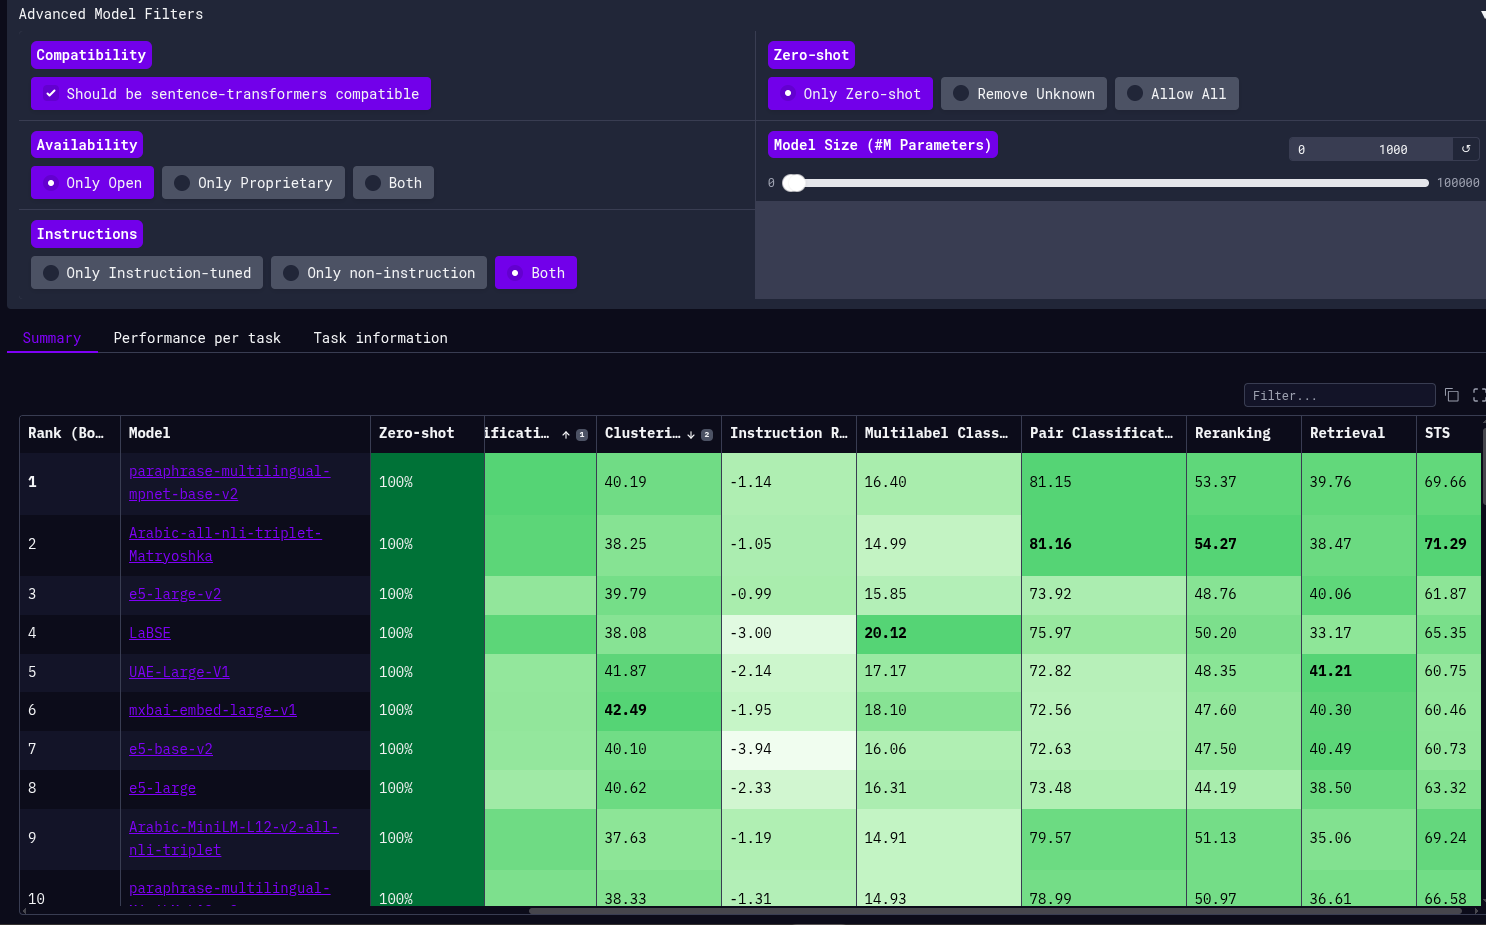

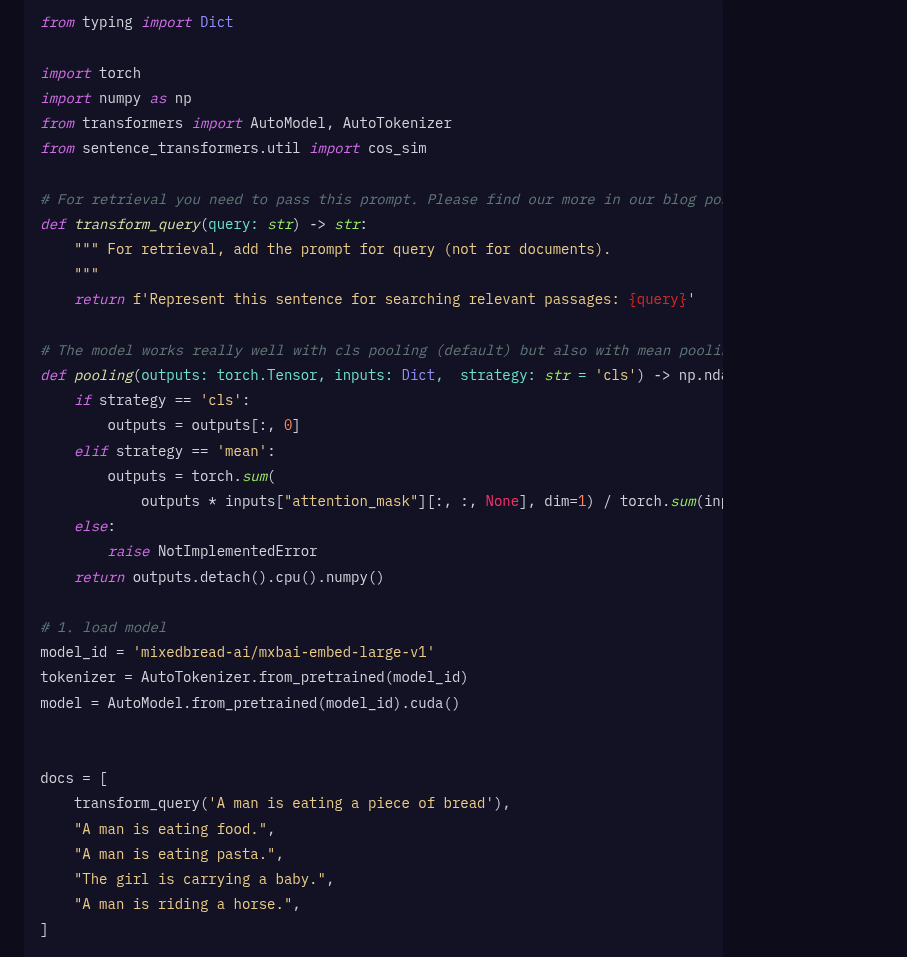

In [ ]:
!pip install mteb mteb[bm25s] --quiet

zsh:1: no matches found: mteb[bm25s]


In [ ]:
# !pip install datasets rank_bm25 --quiet

In [3]:
!pip install -q transformers accelerate einops


In [4]:
from mteb import MTEB, get_model
from mteb.encoder_interface import PromptType
import mteb
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

# Let's evaluate the retriever on a well-known hard retrieval dataset.

In [5]:
from datasets import load_dataset
from rank_bm25 import BM25Okapi
# Load datasets
default = load_dataset("mteb/scifact", split="test")
corpus = load_dataset("mteb/scifact", name="corpus", split="corpus")
queries = load_dataset("mteb/scifact", name="queries", split="queries")

# Build lookup dictionaries
corpus_lookup = {entry["_id"]: entry["text"] for entry in corpus}
query_lookup = {entry["_id"]: entry["text"] for entry in queries}

# Prepare BM25 index
corpus_ids = list(corpus_lookup.keys())
corpus_texts = list(corpus_lookup.values())
bm25 = BM25Okapi([text.lower().split() for text in corpus_texts])

# Function to find gold passage in top-k
results = []
for entry in default:
    if entry["score"] == 1.0:
        query_id = entry["query-id"]
        corpus_id = entry["corpus-id"]
        if query_id in query_lookup and corpus_id in corpus_lookup:
            claim = query_lookup[query_id]
            gold_text = corpus_lookup[corpus_id]

            # Run BM25 retrieval
            top_5_texts = bm25.get_top_n(claim.lower().split(), corpus_texts, n=5)

            # Check if gold passage is among them
            if any(gold_text.strip() == p.strip() for p in top_5_texts):
                results.append({
                    "query_id": query_id,
                    "corpus_id": corpus_id,
                    "claim": claim,
                    "gold_passage": gold_text,
                })

    if len(results) >= 3:
        break

import pandas as pd
results


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.25k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/919 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/339 [00:00<?, ? examples/s]

corpus.jsonl:   0%|          | 0.00/8.02M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/5183 [00:00<?, ? examples/s]

queries.jsonl:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating queries split:   0%|          | 0/1109 [00:00<?, ? examples/s]

[{'query_id': '3',
  'corpus_id': '14717500',
  'claim': '1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.',
  'gold_passage': 'Genome-wide association studies (GWAS) have now identified at least 2,000 common variants that appear associated with common diseases or related traits (http://www.genome.gov/gwastudies), hundreds of which have been convincingly replicated. It is generally thought that the associated markers reflect the effect of a nearby common (minor allele frequency >0.05) causal site, which is associated with the marker, leading to extensive resequencing efforts to find causal sites. We propose as an alternative explanation that variants much less common than the associated one may create "synthetic associations" by occurring, stochastically, more often in association with one of the alleles at the common site versus the other allele. Although synthetic associations are an o

# Testing BM25 and the neural model of choice.

Note: We need to make sure pooling and the query prompt prefix is taken into account on our neural retriever.

In [6]:
class MixedbreadRetriever:
    def __init__(self, model_name="mixedbread-ai/mxbai-embed-large-v1", device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SentenceTransformer(model_name).to(self.device)
        self.query_prompt = "Represent this sentence for searching relevant passages: "

    def encode(self, sentences, task_name, prompt_type=None, **kwargs):
        if prompt_type == PromptType.query:
            sentences = [self.query_prompt + s for s in sentences]
        return self.model.encode(sentences, convert_to_numpy=True, **kwargs)


# Initialize and evaluate
model = MixedbreadRetriever()
tasks = mteb.get_tasks(tasks=["SciFact"])
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(model, output_folder="results/mxbai-s2p",verbosity=1)


def show_metrics(results):# Pretty-print all metrics safely
    for task_result in results:
        print(f"\n🔬 Task: {task_result.task_name}")
        for split, scores_list in task_result.scores.items():
            print(f"  📂 Split: {split}")
            for scores in scores_list:  # loop through each dict in the list
                for metric, value in scores.items():
                    if isinstance(value, (float, int)):
                        print(f"    {metric}: {value:.4f}")
                    else:
                        print(f"    {metric}: {value}")

show_metrics(results)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]


🔬 Task: SciFact
  📂 Split: test
    ndcg_at_1: 0.6267
    ndcg_at_3: 0.6844
    ndcg_at_5: 0.7066
    ndcg_at_10: 0.7389
    ndcg_at_20: 0.7543
    ndcg_at_100: 0.7606
    ndcg_at_1000: 0.7654
    map_at_1: 0.5976
    map_at_3: 0.6602
    map_at_5: 0.6760
    map_at_10: 0.6925
    map_at_20: 0.6972
    map_at_100: 0.6980
    map_at_1000: 0.6983
    recall_at_1: 0.5976
    recall_at_3: 0.7239
    recall_at_5: 0.7799
    recall_at_10: 0.8716
    recall_at_20: 0.9306
    recall_at_100: 0.9650
    recall_at_1000: 1.0000
    precision_at_1: 0.6267
    precision_at_3: 0.2644
    precision_at_5: 0.1747
    precision_at_10: 0.0993
    precision_at_20: 0.0528
    precision_at_100: 0.0109
    precision_at_1000: 0.0011
    mrr_at_1: 0.6267
    mrr_at_3: 0.6800
    mrr_at_5: 0.6913
    mrr_at_10: 0.7028
    mrr_at_20: 0.7069
    mrr_at_100: 0.7077
    mrr_at_1000: 0.7079
    nauc_ndcg_at_1_max: 0.6057
    nauc_ndcg_at_1_std: 0.0896
    nauc_ndcg_at_1_diff1: 0.7775
    nauc_ndcg_at_3_max: 0.6313
 

In [7]:
model = get_model("bm25s")

evaluation = MTEB(tasks=["SciFact"])
results = evaluation.run(model, output_folder="results/bm25-s2p", verbosity=1)

/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:120: UserWarning: Passing task names as strings is deprecated and will be removed in 2.0 release. Please use `tasks = mteb.get_tasks(tasks=[...])` method to get tasks instead.
  warnings.warn(


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Split strings:   0%|          | 0/5183 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/5183 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/5183 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/5183 [00:00<?, ?it/s]

Split strings:   0%|          | 0/300 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/300 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/300 [00:00<?, ?it/s]

In [8]:
show_metrics(results)


🔬 Task: SciFact
  📂 Split: test
    ndcg_at_1: 0.5500
    ndcg_at_3: 0.6462
    ndcg_at_5: 0.6577
    ndcg_at_10: 0.6863
    ndcg_at_20: 0.6967
    ndcg_at_100: 0.7079
    ndcg_at_1000: 0.7152
    map_at_1: 0.5342
    map_at_3: 0.6182
    map_at_5: 0.6255
    map_at_10: 0.6387
    map_at_20: 0.6420
    map_at_100: 0.6439
    map_at_1000: 0.6442
    recall_at_1: 0.5342
    recall_at_3: 0.7086
    recall_at_5: 0.7362
    recall_at_10: 0.8187
    recall_at_20: 0.8569
    recall_at_100: 0.9127
    recall_at_1000: 0.9700
    precision_at_1: 0.5500
    precision_at_3: 0.2511
    precision_at_5: 0.1587
    precision_at_10: 0.0907
    precision_at_20: 0.0478
    precision_at_100: 0.0104
    precision_at_1000: 0.0011
    mrr_at_1: 0.5500
    mrr_at_3: 0.6317
    mrr_at_5: 0.6385
    mrr_at_10: 0.6492
    mrr_at_20: 0.6517
    mrr_at_100: 0.6528
    mrr_at_1000: 0.6530
    nauc_ndcg_at_1_max: 0.4057
    nauc_ndcg_at_1_std: 0.0909
    nauc_ndcg_at_1_diff1: 0.6774
    nauc_ndcg_at_3_max: 0.4528
 

# RAG

We will make a RAG system with access to knowledge about transformers and RAG research papers released in 2025 (after knowledge cut-off of most commercial LLMs). This is a good use case for RAG.

arXiv Scraping for 2025 Papers (Out-of-Distribution)

To simulate a true *retrieval-augmented generation* (RAG) scenario, this section fetches **cutting-edge papers from 2025** — beyond the LLM’s training cutoff.

- **Search Logic**  
  Constructs a query for arXiv's API that includes:  
  `transformer AND retrieval AND augmented AND generation`, sorted by most recent submissions.

- **Year Filter**  
  Only papers **published in 2025** are retained to ensure the content is *unseen* by the LLM, forcing it to rely on retrieval instead of memorization.



In [9]:
!pip install feedparser --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.6 MB/s eta 0:00:00


In [10]:
import feedparser
import urllib.parse
import datetime

# Your search query (with AND logic)
query_terms = "all:transformer AND all:retrieval AND all:augmented AND all:generation"
encoded_query = urllib.parse.quote(query_terms)

# Construct the final URL with encoded query
base_url = "http://export.arxiv.org/api/query?"
params = f"search_query={encoded_query}&start=0&max_results=100&sortBy=submittedDate&sortOrder=descending"
search_url = base_url + params

# Parse the feed
feed = feedparser.parse(search_url)

# Filter results to only those published in 2025
papers_2025 = [
    entry for entry in feed.entries
    if datetime.datetime(*entry.published_parsed[:3]).year == 2025
]

# Print results
for i, entry in enumerate(papers_2025, 1):
    print(f"{i}. {entry.title}")
    print(f"   Authors: {', '.join(author.name for author in entry.authors)}")
    print(f"   Published: {entry.published}")
    print(f"   Link: {entry.link}")
    print()
    if i>=10:
      break


1. PersonaBOT: Bringing Customer Personas to Life with LLMs and RAG
   Authors: Muhammed Rizwan, Lars Carlsson, Mohammad Loni
   Published: 2025-05-22T13:04:34Z
   Link: http://arxiv.org/abs/2505.17156v1

2. Agentic Publications: An LLM-Driven Framework for Interactive Scientific
  Publishing, Supplementing Traditional Papers with AI-Powered Knowledge
  Systems
   Authors: Roberto Pugliese, George Kourousias, Francesco Venier, Grazia Garlatti Costa
   Published: 2025-05-19T15:28:10Z
   Link: http://arxiv.org/abs/2505.13246v1

3. Automated Bias Assessment in AI-Generated Educational Content Using CEAT
  Framework
   Authors: Jingyang Peng, Wenyuan Shen, Jiarui Rao, Jionghao Lin
   Published: 2025-05-19T05:19:26Z
   Link: http://arxiv.org/abs/2505.12718v1

4. HAKES: Scalable Vector Database for Embedding Search Service
   Authors: Guoyu Hu, Shaofeng Cai, Tien Tuan Anh Dinh, Zhongle Xie, Cong Yue, Gang Chen, Beng Chin Ooi
   Published: 2025-05-18T19:26:29Z
   Link: http://arxiv.org/abs/25

# Using gpt-4o-mini as our generative model.

In [11]:
from openai import AsyncAzureOpenAI
from google.colab import userdata
# API_KEY = userdata.get("AZURE_KEY")
API_KEY = "42A0iGSDFlNuPffEdDxWzS55NmNeiu3S3sp6r6v0DQlMvyRhOV2UJQQJ99BEACHYHv6XJ3w3AAAAACOGjbYN"
ENDPOINT = "https://mxgub-mb16new7-eastus2.cognitiveservices.azure.com/"
MODEL = "gpt-4o-mini"
DEPLOYMENT = "gpt-4o-mini-maxi"

azure_client = AsyncAzureOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint=ENDPOINT,
    api_key=API_KEY
)

In [12]:
def build_input(prompt_messages):
    return [{"role": m["role"], "content": m["content"]} for m in prompt_messages]

# Generate response using Azure OpenAI
async def generate_response(prompt_messages, max_tokens=512):
    messages = build_input(prompt_messages)
    response = await azure_client.chat.completions.create(
        model=DEPLOYMENT,
        messages=messages,
        max_tokens=max_tokens,
        temperature=0.7,
    )
    return response.choices[0].message.content.strip()


This section handles the end-to-end process of downloading, processing, and embedding scientific PDFs for use in retrieval systems.

- **PDF Downloading**  
  Paper URLs are converted to direct `.pdf` links and saved locally to the `pdfs/` directory.

- **Text Chunking**  
  Each PDF is loaded with `LangChain`'s `PyPDFLoader`, then split into manageable chunks using `RecursiveCharacterTextSplitter` to preserve context.

- **Embedding Model Wrapper**  
  A custom `LangchainSentenceTransformer` class wraps a SentenceTransformer model (`mxbai-embed-large-v1`) to:
  - Filter out noisy or irrelevant content.
  - Encode documents and queries into vector embeddings.
  - Use a search-specific prefix for query encoding.

- **Output**  
  The script returns clean document chunks and their corresponding embeddings, ready to be indexed in a vector store like FAISS.




In [13]:
!pip install -U langchain_community --quiet
!pip install pypdf --quiet
!pip install instructor --quiet
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.6/345.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 22.4 MB/s eta 0:00:00


In [14]:
import os
import torch
import requests
import numpy as np
from tqdm import tqdm
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from sentence_transformers import SentenceTransformer

# --- Embedding Wrapper ---
class LangchainSentenceTransformer:
    def __init__(self, model_name="mixedbread-ai/mxbai-embed-large-v1"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = SentenceTransformer(model_name).to(self.device)
        self.query_prefix = "Represent this sentence for searching relevant passages: "
        self._cleaned_documents = []

    def embed_documents(self, documents):
        bad_substrings = [
            "Atomic Structure Representation",
            "Logical path\nD\nF\nC\nA\nE"
        ]

        print(f"[INFO] Filtering {len(documents)} chunks...")
        filtered = []
        for doc in documents:
            text = getattr(doc, "page_content", str(doc)).strip()
            if isinstance(text, str) and text and not any(bad in text for bad in bad_substrings):
                filtered.append(Document(page_content=text))

        self._cleaned_documents = filtered
        texts = [doc.page_content for doc in filtered]

        print(f"[INFO] Embedding {len(texts)} clean chunks...")
        embeddings = self.model.encode(
            texts,
            show_progress_bar=True,
            convert_to_numpy=True,
            device=self.device
        )
        return texts, embeddings

    def embed_query(self, query):
        return self.model.encode(
            [self.query_prefix + str(query)],
            convert_to_numpy=True,
            device=self.device
        )[0]

    def __call__(self, text: str) -> list[float]:
        return self.embed_query(text)


In [15]:
### Chunking and Embedding our research paper chunks with FAISS vector db.

os.makedirs("pdfs", exist_ok=True)

def download_pdf(pdf_url, filename):
    response = requests.get(pdf_url)
    with open(filename, "wb") as f:
        f.write(response.content)

# --- Downloading raw pdf ---
pdf_links = [entry.link.replace("abs", "pdf") + ".pdf" for entry in papers_2025]

for i, url in enumerate(tqdm(pdf_links, desc="Downloading PDFs")):
    filename = f"pdfs/paper_{i}.pdf"
    if not os.path.exists(filename):
        try:
            download_pdf(url, filename)
        except Exception as e:
            print(f"Failed to download {url}: {e}")

# --- Load and split PDFs ---
all_docs = []
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

for i in tqdm(range(len(pdf_links)), desc="Processing PDFs"):
    file_path = f"pdfs/paper_{i}.pdf"
    try:
        loader = PyPDFLoader(file_path)
        documents = loader.load()
        chunks = splitter.split_documents(documents)
        all_docs.extend(chunks)
    except Exception as e:
        print(f"[WARN] Failed to process {file_path}: {e}")

print(f"[INFO] Total document chunks: {len(all_docs)}")


# --- Embed and Save FAISS ---
embedding_model = LangchainSentenceTransformer()
texts, embeddings = embedding_model.embed_documents(all_docs)

Processing PDFs: 100%|██████████| 95/95 [01:43<00:00,  1.09s/it]


[INFO] Total document chunks: 8713
[INFO] Filtering 8713 chunks...
[INFO] Embedding 8709 clean chunks...


Batches:   0%|          | 0/273 [00:00<?, ?it/s]

In [16]:
text_embedding_pairs = list(zip(texts, embeddings))
vectorstore = FAISS.from_embeddings(text_embedding_pairs, embedding_model)
vectorstore.save_local("faiss_index_mixedbread")

print("[✅ SUCCESS] Vector store saved. Ready for retrieval.")

[✅ SUCCESS] Vector store saved. Ready for retrieval.


In [17]:
# Zip the folder
!zip -r faiss_index_mixedbread.zip faiss_index_mixedbread

# Provide download link
from google.colab import files
files.download("faiss_index_mixedbread.zip")


  adding: faiss_index_mixedbread/ (stored 0%)
  adding: faiss_index_mixedbread/index.pkl (deflated 68%)
  adding: faiss_index_mixedbread/index.faiss (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# --- Query the Vectorstore ---
query = "How can implement retrieval-augmented generation in 2025?"
results = vectorstore.similarity_search(query, k=5)

# Print the results
for i, doc in enumerate(results, 1):
    print(f"{i}. {doc.page_content.strip()}\n")


1. · Rank Fusion.
1 Introduction
Retrieval Augmented Generation (RAG) is a transformative approach that en-
hances the capabilities of large language models (LLMs) by integrating external
information retrieval directly into the text generation process. This method al-
lows LLMs to dynamically access and utilize relevant external knowledge, sig-
nificantly improving their ability to generate accurate, contextually grounded,
and informative responses. Unlike static LLMs that rely solely on pre-trained
data, RAG-enabled models can access up-to-date and domain-specific informa-
tion. This dynamic integration ensures that the generated content remains both
relevant and accurate, even in rapidly evolving or specialized fields.
⋆ Equal contribution.
arXiv:2504.19754v1  [cs.IR]  28 Apr 2025

2. Figure 1: Architecture of Retrieval-Augmented Generation
3.3. Retrieval-Augmented Generation
Retrieval-Augmented Generation (RAG) [24] represents a fusion of information retrieval and
language generatio

# How do we evaluate RAG?
- Evaluation example: LLM-as-judge.
- Let's build a tiny set of queries to test.



In [19]:
queries = [
    "What are the main challenges in combining retrieval with large language models for scientific generation?",
    "How does retrieval-augmented generation compare to fine-tuning in biomedical literature tasks?",
    "What transformer-based architectures are optimized for retrieval-heavy workflows?",
    "How is context selection handled in long-document RAG pipelines?",
    "What evaluation metrics are used to assess RAG effectiveness in QA tasks?",
    "Summarize how contrastive learning is used in retrieval for generative models.",
    "Is memory compression relevant to retrieval-augmented generation? How?",
    "What is the role of external knowledge sources in improving hallucination resistance in RAG?",
    "Describe multi-hop retrieval in the context of scientific question answering.",
    "What datasets are commonly used to evaluate transformer-based RAG systems in 2025?",
]


from typing import List

def build_input(prompt_messages):
    return [{"role": "system", "content": "You are a helpful research assistant."}] + [
        {"role": "user", "content": m} for m in prompt_messages
    ]

async def rag_query(query: str, k: int = 5):
    results = vectorstore.similarity_search(query, k=k)
    context = "\n\n".join(f"{i+1}. {doc.page_content.strip()}" for i, doc in enumerate(results))

    prompt = f"""Use the following retrieved documents to answer the question. Be concise, precise, and grounded in the content.

DOCUMENTS:
{context}

QUESTION:
{query}
"""
    answer = await generate_response([prompt])
    return answer


In [20]:
import asyncio

k = 5  # you can adjust this to control context size
query = queries[0]  # Try the first one

answer = await rag_query(query, k=k)
print(f"Q: {query}\n\nA: {answer}")


Q: What are the main challenges in combining retrieval with large language models for scientific generation?

A: The main challenges in combining retrieval with large language models (LLMs) for scientific generation include:

1. **Input Constraints**: Traditional chunking methods used to manage vast volumes of external knowledge often lead to fragmented context, which can result in incomplete retrieval and diminished coherence in generated outputs (Document 1).

2. **Performance Overestimation**: Existing benchmarks may overestimate the performance of long-context language models (LCLMs) by providing overly simplified contexts, which do not accurately reflect realistic scenarios (Document 2).

3. **Context Fragmentation**: The fixed-size segments created by chunking can disrupt the continuity of information, making it difficult for LLMs to generate coherent and contextually relevant responses (Document 1).

4. **Complexity of Retrieval and Reasoning**: The integration of retrieval proc

# We define ELO Ranking to compare prompt hyperparameters.

### In this case, the number of retrieved documents formatted into the prompt.

This script evaluates retrieval-augmented generation (RAG) performance across different values of k (number of documents retrieved) using an Elo rating system.

Elo Scoring: Each variant starts with a base score (1500). Pairs of answers are compared, and scores are updated based on wins/losses using an Elo update rule.

Answer Generation: For each query, answers are generated using varying k-values from a vector store.

Judgment: Answers are compared in pairs using an LLM, scored on faithfulness, completeness, and clarity, and a winner is selected.

In [21]:
from collections import defaultdict
import json
import pandas as pd
from tqdm import tqdm
from pydantic import BaseModel, Field
import instructor

# Wrap OpenAI client for structured output
instructor_client = instructor.from_openai(azure_client)

# --- Elo setup ---
elo_scores = defaultdict(lambda: 1500)
K = 32

def expected_score(r1, r2):
    return 1 / (1 + 10 ** ((r2 - r1) / 400))

def update_elo(a, b, result):
    ra, rb = elo_scores[a], elo_scores[b]
    ea = expected_score(ra, rb)
    eb = expected_score(rb, ra)
    elo_scores[a] += K * (result - ea)
    elo_scores[b] += K * ((1 - result) - eb)

# --- Judgment schema ---
class WinnerResponse(BaseModel):
    thinking: str = Field(description="Explanation of the reasoning used to judge the answers.")
    faithfulness_score: int = Field(ge=0, le=10, description="How factually grounded the answer is.")
    completeness_score: int = Field(ge=0, le=10, description="How complete the answer is.")
    clarity_score: int = Field(ge=0, le=10, description="How clearly the answer is written.")
    winner: str = Field(description='Either "A" or "B", indicating the better answer.')

# --- Main evaluation ---
async def run_rag_k_elo_evaluation(queries, vectorstore, ks=[3, 5, 10]):
    print("🏁 Starting Elo evaluation for k values...\n")
    results_log = []

    for query in tqdm(queries, total=len(queries)):
        answers = {}

        for k in ks:
            docs = vectorstore.similarity_search(query, k=k)
            context = "\n\n".join(f"{i+1}. {doc.page_content.strip()}" for i, doc in enumerate(docs))
            prompt = f"""Use the following retrieved documents to answer the question.

DOCUMENTS:
{context}

QUESTION:
{query}
"""
            response = await azure_client.chat.completions.create(
                model=DEPLOYMENT,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant for scientific research."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=512,
                temperature=0.7,
            )
            answers[f"rag_k{k}"] = response.choices[0].message.content.strip()

        for i in range(len(ks)):
            for j in range(i + 1, len(ks)):
                k1, k2 = ks[i], ks[j]
                a_key, b_key = f"rag_k{k1}", f"rag_k{k2}"
                answer_a, answer_b = answers[a_key], answers[b_key]

                judge_prompt = [
                    {"role": "system", "content": "You are an expert scientific reviewer. Compare two answers."},
                    {"role": "user", "content": f"""
QUESTION: {query}

ANSWER A:
{answer_a}

ANSWER B:
{answer_b}

Evaluate each answer on: faithfulness, completeness, and clarity (0-10 scale).
Then explain your reasoning and choose the better answer as:
{{ "winner": "A", "thinking": "...", "faithfulness_score": X, "completeness_score": Y, "clarity_score": Z }}
"""}
                ]

                try:
                    result_obj = await instructor_client.chat.completions.create(
                        model=DEPLOYMENT,
                        messages=judge_prompt,
                        response_model=WinnerResponse
                    )
                    winner = result_obj.winner
                except Exception as e:
                    print(f"⚠️ Judgment failed: {e}")
                    winner = "UNKNOWN"
                    result_obj = None

                if winner == "A":
                    update_elo(a_key, b_key, 1)
                    final_winner = a_key
                elif winner == "B":
                    update_elo(a_key, b_key, 0)
                    final_winner = b_key
                else:
                    update_elo(a_key, b_key, 0.5)
                    final_winner = "ambiguous"

                print(f"⚖️ Compared {a_key} vs {b_key} → 🏆 {final_winner}")

                results_log.append({
                    "query": query,
                    "a_key": a_key,
                    "b_key": b_key,
                    "answer_a": answer_a,
                    "answer_b": answer_b,
                    "winner": winner,
                    "final_winner": final_winner,
                    "thinking": getattr(result_obj, "thinking", None),
                    "faithfulness_score": getattr(result_obj, "faithfulness_score", None),
                    "completeness_score": getattr(result_obj, "completeness_score", None),
                    "clarity_score": getattr(result_obj, "clarity_score", None),
                })

    # --- Results ---
    print("\n🏆 Final Elo Scores:")
    sorted_elo = sorted(elo_scores.items(), key=lambda x: -x[1])
    for model, score in sorted_elo:
        print(f"{model}: {score:.1f}")

    df = pd.DataFrame(results_log)
    df.to_csv("elo_k_comparison_log.csv", index=False)
    print("\n📄 Log saved to 'elo_k_comparison_log.csv'")

    summary = {
        "variants": ks,
        "rankings": sorted_elo,
        "elo_scores": dict(elo_scores),
        "overall_winner": sorted_elo[0][0],
        "pairwise_comparisons": results_log
    }
    with open("elo_k_comparison_metrics.json", "w") as f:
        json.dump(summary, f, indent=2)
    print("📊 Metrics saved to 'elo_k_comparison_metrics.json'")


await run_rag_k_elo_evaluation(queries, vectorstore, ks=[2,3,5,10,12,15])



🏁 Starting Elo evaluation for k values...



  0%|          | 0/10 [00:00<?, ?it/s]

⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k10
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k10


 10%|█         | 1/10 [01:13<11:04, 73.80s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k3
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k5
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k10
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k10


 20%|██        | 2/10 [02:24<09:36, 72.05s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k3
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k5
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k5
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k10


 30%|███       | 3/10 [03:26<07:51, 67.34s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k3
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k5
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k5
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k10
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k15


 40%|████      | 4/10 [04:23<06:20, 63.36s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k5
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k10
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k10


 50%|█████     | 5/10 [05:10<04:47, 57.45s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k3
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k5
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k10
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k10


 60%|██████    | 6/10 [06:05<03:46, 56.67s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k3
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k5
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k10
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k15


 70%|███████   | 7/10 [06:55<02:43, 54.40s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k3
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k5
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k5
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k5
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k10


 80%|████████  | 8/10 [07:55<01:52, 56.34s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k2
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k2
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k3
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k10
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k10


 90%|█████████ | 9/10 [09:02<00:59, 59.47s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k3 → 🏆 rag_k3
⚖️ Compared rag_k2 vs rag_k5 → 🏆 rag_k5
⚖️ Compared rag_k2 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k2 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k2 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k3 vs rag_k5 → 🏆 rag_k5
⚖️ Compared rag_k3 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k3 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k3 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k5 vs rag_k10 → 🏆 rag_k10
⚖️ Compared rag_k5 vs rag_k12 → 🏆 rag_k12
⚖️ Compared rag_k5 vs rag_k15 → 🏆 rag_k15
⚖️ Compared rag_k10 vs rag_k12 → 🏆 rag_k10
⚖️ Compared rag_k10 vs rag_k15 → 🏆 rag_k15


100%|██████████| 10/10 [10:00<00:00, 60.08s/it]

⚖️ Compared rag_k12 vs rag_k15 → 🏆 rag_k15

🏆 Final Elo Scores:
rag_k10: 1607.3
rag_k15: 1586.6
rag_k12: 1550.9
rag_k5: 1469.8
rag_k3: 1445.8
rag_k2: 1339.6

📄 Log saved to 'elo_k_comparison_log.csv'
📊 Metrics saved to 'elo_k_comparison_metrics.json'


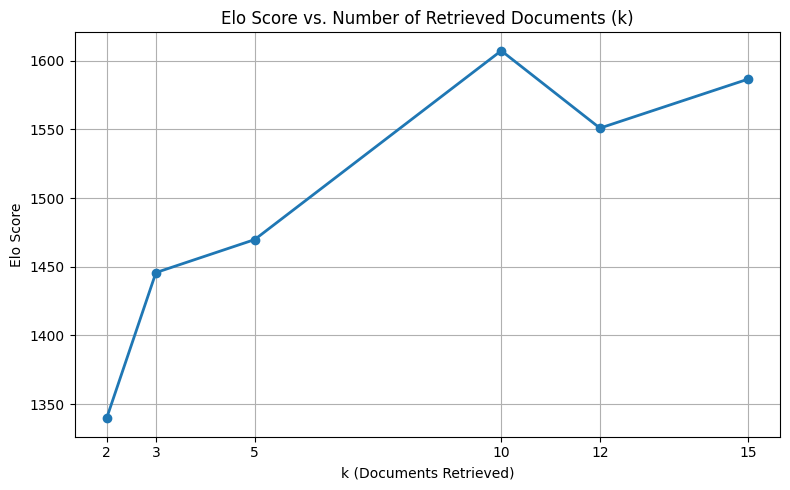

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Load Elo scores
with open("elo_k_comparison_metrics.json", "r") as f:
    summary = json.load(f)

# Extract k and scores
elo_data = [
    (int(name.split("_k")[1]), score)
    for name, score in summary["elo_scores"].items()
    if name.startswith("rag_k")
]

# Sort by k
elo_data.sort(key=lambda x: x[0])
ks, scores = zip(*elo_data)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(ks, scores, marker="o", linewidth=2)
plt.title("Elo Score vs. Number of Retrieved Documents (k)")
plt.xlabel("k (Documents Retrieved)")
plt.ylabel("Elo Score")
plt.grid(True)
plt.xticks(ks)
plt.tight_layout()
plt.show()
